In [4]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import warnings
warnings.filterwarnings('ignore')

In [5]:
class CustomerServiceAnalyzer:
    def __init__(self):
        self.classifier = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            class_weight='balanced',
            random_state=42
        )
        self.vectorizer = TfidfVectorizer(
            min_df=2,
            max_df=0.85,
            ngram_range=(1, 2),
            token_pattern=r'\b\w+\b',
            stop_words=['and', 'the', 'is', 'a', 'an', 'in', 'on', 'at', 'for']
        )
        
        self.responses = {
            'positive': [
                "Thank you for your positive feedback!",
                "We're glad you're satisfied with our service.",
                "Your happiness is our priority!",
                "We appreciate your kind words!",
                "Wonderful to hear! How else can we help?"
            ],
            'neutral': [
                "Thank you for your feedback.",
                "We appreciate your input.",
                "How else can we assist you?",
                "Let me look into that for you.",
                "I understand your situation."
            ],
            'negative': [
                "We apologize for any inconvenience.",
                "Let us know how we can improve.",
                "We'll work on addressing your concerns.",
                "I'm sorry you're having this experience.",
                "Let me help resolve this issue."
            ]
        }

    def preprocess_text(self, text):
        """Enhanced text preprocessing"""
        # Convert to lowercase
        text = text.lower()
        
        # Replace common contractions
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'m", " am", text)
        text = re.sub(r"'ll", " will", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'re", " are", text)
        
        # Keep exclamation marks as they indicate sentiment
        text = re.sub(r'!+', ' ! ', text)
        
        # Remove other special characters and digits
        text = re.sub(r'[^a-z\s!]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text

    def add_custom_features(self, text):
        """Add sentiment-specific features"""
        # Count exclamation marks
        exclamation_count = text.count('!')
        
        # Check for positive/negative words
        positive_words = ['excellent', 'great', 'good', 'best', 'love', 'perfect', 'thank', 'amazing']
        negative_words = ['bad', 'worst', 'terrible', 'horrible', 'poor', 'awful', 'waste']
        
        positive_count = sum(1 for word in text.split() if word in positive_words)
        negative_count = sum(1 for word in text.split() if word in negative_words)
        
        return f"{text} sentiment_exc_{exclamation_count} sentiment_pos_{positive_count} sentiment_neg_{negative_count}"

    def prepare_sample_data(self):
        """Generate dataset with better sentiment indicators"""
        data = {
            'customer_message': [
                # 20 Positive messages with clear sentiment indicators
                "Excellent service and quick delivery!",
                "Great experience, very helpful support team!",
                "Perfect product, exactly what I wanted!",
                "Best customer service ever, thank you!",
                "Amazing quality, exceeded expectations!",
                "Love this product, works perfectly!",
                "Outstanding service, highly recommend!",
                "Fantastic support team, very professional!",
                "Exceptional quality and fast shipping!",
                "Brilliant service, thank you so much!",
                "Wonderful experience from start to finish!",
                "Superb product quality, very satisfied!",
                "Incredible service, beyond expectations!",
                "Excellent team, very knowledgeable!",
                "Perfect delivery, well packaged!",
                "Great company, amazing service!",
                "Absolutely love the product quality!",
                "Exceptional support team!",
                "Outstanding experience overall!",
                "Fantastic product and service!",
                
                # 20 Neutral messages with clear inquiry focus
                "What is the delivery timeframe?",
                "How do I track my order?",
                "Where can I find size information?",
                "Is this available in other colors?",
                "What are the shipping options?",
                "How do I return an item?",
                "Can you explain the warranty?",
                "What payment methods are accepted?",
                "Is international shipping available?",
                "Where are you located?",
                "How long is the warranty period?",
                "Do you offer bulk discounts?",
                "What are your business hours?",
                "Is assembly required?",
                "How do I change my password?",
                "Are spare parts available?",
                "What is the return window?",
                "Do you have a catalog?",
                "How much is shipping?",
                "Can I modify my order?",
                
                # 20 Negative messages with clear negative indicators
                "Terrible service, never again!",
                "Worst experience ever, very disappointed!",
                "Product arrived damaged, awful packaging!",
                "Horrible customer service, no response!",
                "Complete waste of money and time!",
                "Poor quality, falling apart already!",
                "Absolutely terrible experience!",
                "Worst company I have dealt with!",
                "Extremely poor service quality!",
                "Disappointing product, does not work!",
                "Awful experience, avoid this company!",
                "Very poor customer support!",
                "Completely dissatisfied with service!",
                "Bad quality, immediate issues!",
                "Terrible delivery service!",
                "Worst purchase ever made!",
                "Extremely disappointed, poor quality!",
                "Horrible experience overall!",
                "Dreadful service quality!",
                "Unacceptable product condition!"
            ],
            'sentiment': ['positive'] * 20 + ['neutral'] * 20 + ['negative'] * 20
        }
        df = pd.DataFrame(data)
        
        # Preprocess and add custom features
        df['processed_message'] = df['customer_message'].apply(
            lambda x: self.add_custom_features(self.preprocess_text(x))
        )
        return df

    def train_model(self, data):
        """Train the enhanced classifier"""
        X = self.vectorizer.fit_transform(data['processed_message'])
        y = data['sentiment']
        
        # Perform cross-validation
        cv_scores = cross_val_score(self.classifier, X, y, cv=5)
        
        # Train final model
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        self.classifier.fit(X_train, y_train)
        y_pred = self.classifier.predict(X_test)
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': self.vectorizer.get_feature_names_out(),
            'importance': self.classifier.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'cv_scores': cv_scores,
            'feature_importance': feature_importance.head(10),
            'test_size': len(y_test)
        }

    def generate_response(self, message):
        """Generate response using the enhanced model"""
        processed_message = self.add_custom_features(self.preprocess_text(message))
        X = self.vectorizer.transform([processed_message])
        sentiment = self.classifier.predict(X)[0]
        return np.random.choice(self.responses[sentiment]), sentiment

    def visualize_results(self, data, metrics):
    
        plt.figure(figsize=(8, 6))
        sentiment_counts = data['sentiment'].value_counts()
        sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
        plt.title('Sentiment Distribution')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.show()
    
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['confusion_matrix'], 
                    annot=True, 
                    fmt='d',
                    xticklabels=['Negative', 'Neutral', 'Positive'],
                    yticklabels=['Negative', 'Neutral', 'Positive'],
                    cmap="Blues")
        plt.title('Confusion Matrix')
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.boxplot(metrics['cv_scores'])
        plt.title('Cross-validation Scores')
        plt.ylabel('Accuracy')
        plt.show()
    
        # Top 10 Important Features
        plt.figure(figsize=(8, 6))
        importance_data = metrics['feature_importance'].head(10)
        sns.barplot(x='importance', y='feature', data=importance_data)
        plt.title('Top 10 Important Features')
        plt.show()


Model Accuracy: 0.83

Cross-validation scores: 0.92 (+/- 0.11)

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80         4
     neutral       1.00      1.00      1.00         4
    positive       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.89      0.83      0.82        12
weighted avg       0.89      0.83      0.82        12


Top 10 Important Features:
                            feature  importance
50                  sentiment_exc_1    0.126750
49  sentiment_exc_0 sentiment_pos_0    0.119633
48                  sentiment_exc_0    0.119264
51  sentiment_exc_1 sentiment_pos_0    0.079638
54                  sentiment_neg_0    0.072609
58  sentiment_pos_0 sentiment_neg_1    0.064462
56                  sentiment_pos_0    0.064310
55                  sentiment_neg_1    0.058134
57  sentiment_pos_0 sentiment_neg_0    0.055305
59                  sent

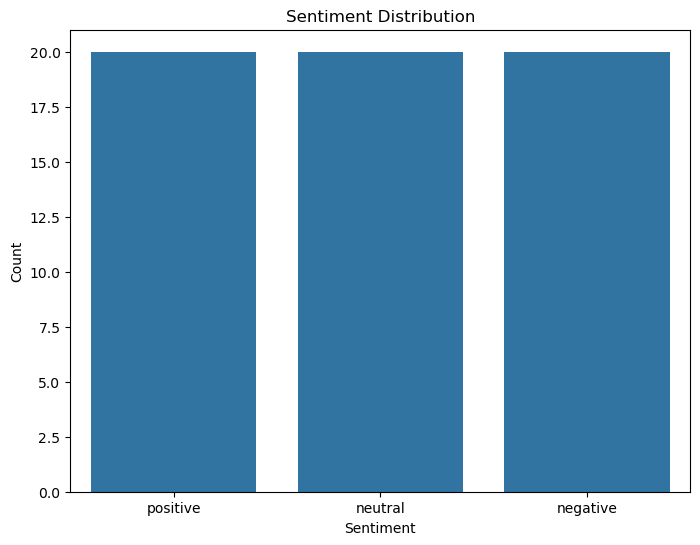

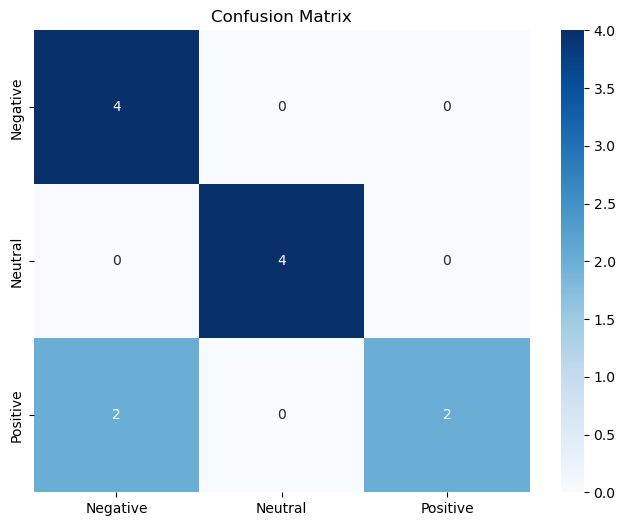

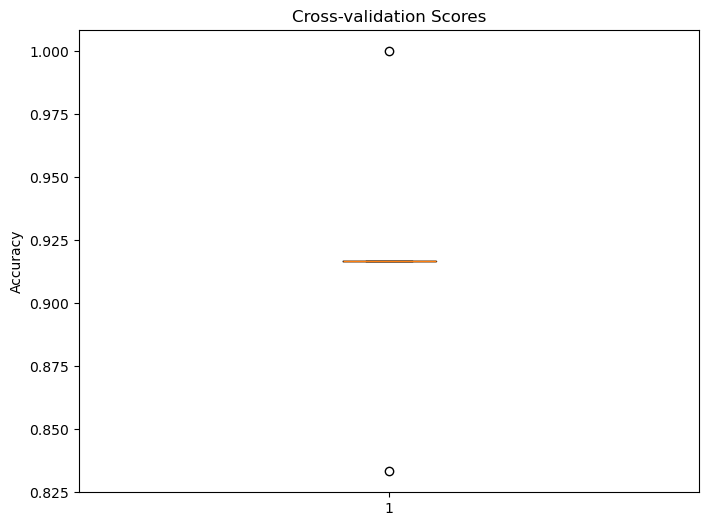

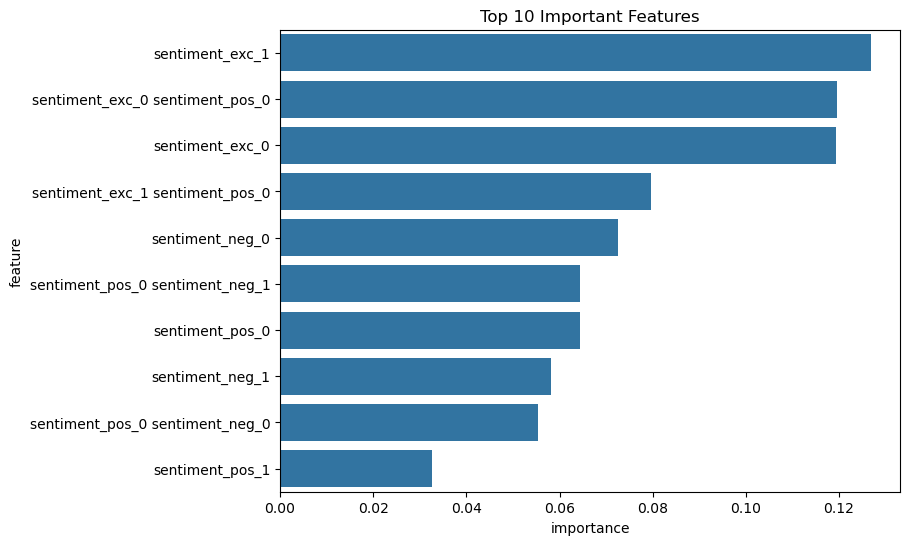


Example Responses:

Customer: I love your product!
Sentiment: positive
Response: Thank you for your positive feedback!

Customer: Still waiting for a response...
Sentiment: neutral
Response: I understand your situation.

Customer: This is unacceptable service
Sentiment: neutral
Response: Let me look into that for you.

Customer: Could you tell me about shipping?
Sentiment: neutral
Response: Thank you for your feedback.

Customer: When will my order arrive?
Sentiment: neutral
Response: Let me look into that for you.


In [6]:
def main():
    analyzer = CustomerServiceAnalyzer()
    data = analyzer.prepare_sample_data()
    
    # Train the model and get metrics
    metrics = analyzer.train_model(data)
    print(f"Model Accuracy: {metrics['accuracy']:.2f}")
    print(f"\nCross-validation scores: {metrics['cv_scores'].mean():.2f} (+/- {metrics['cv_scores'].std() * 2:.2f})")
    print("\nClassification Report:")
    print(metrics['classification_report'])
    print("\nTop 10 Important Features:")
    print(metrics['feature_importance'])
    
    # Visualize results
    analyzer.visualize_results(data, metrics)
    
    # Example conversation
    test_messages = [
        "I love your product!",
        "Still waiting for a response...",
        "This is unacceptable service",
        "Could you tell me about shipping?",
        "When will my order arrive?"
    ]
    
    print("\nExample Responses:")
    for message in test_messages:
        response, sentiment = analyzer.generate_response(message)
        print(f"\nCustomer: {message}")
        print(f"Sentiment: {sentiment}")
        print(f"Response: {response}")

if __name__ == "__main__":
    main()